In [9]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08


In [10]:
!pip install torchattacks

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torchattacks
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

# Prepare training and test datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# model architecture
class resnet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits


# Initialize model and move to device
model = resnet(len(classes))
model = model.to(device)

In [18]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 50

In [22]:
!ls

data  model  src


Epoch 1/50: Training Loss: 0.1838 Accuracy: 0.9351
Epoch 2/50: Training Loss: 0.1515 Accuracy: 0.9464
Epoch 3/50: Training Loss: 0.1322 Accuracy: 0.9537
Epoch 4/50: Training Loss: 0.1138 Accuracy: 0.9600
Epoch 5/50: Training Loss: 0.0923 Accuracy: 0.9679
Epoch 6/50: Training Loss: 0.0861 Accuracy: 0.9691
Epoch 7/50: Training Loss: 0.0707 Accuracy: 0.9750
Epoch 8/50: Training Loss: 0.0623 Accuracy: 0.9779
Epoch 9/50: Training Loss: 0.0525 Accuracy: 0.9816
Epoch 10/50: Training Loss: 0.0551 Accuracy: 0.9816
Epoch 11/50: Training Loss: 0.0550 Accuracy: 0.9808
Epoch 12/50: Training Loss: 0.0431 Accuracy: 0.9854
Epoch 13/50: Training Loss: 0.0366 Accuracy: 0.9875
Epoch 14/50: Training Loss: 0.0358 Accuracy: 0.9880
Epoch 15/50: Training Loss: 0.0317 Accuracy: 0.9888
Epoch 16/50: Training Loss: 0.0295 Accuracy: 0.9895
Epoch 17/50: Training Loss: 0.0276 Accuracy: 0.9907
Epoch 18/50: Training Loss: 0.0282 Accuracy: 0.9903
Epoch 19/50: Training Loss: 0.0272 Accuracy: 0.9910
Epoch 20/50: Training

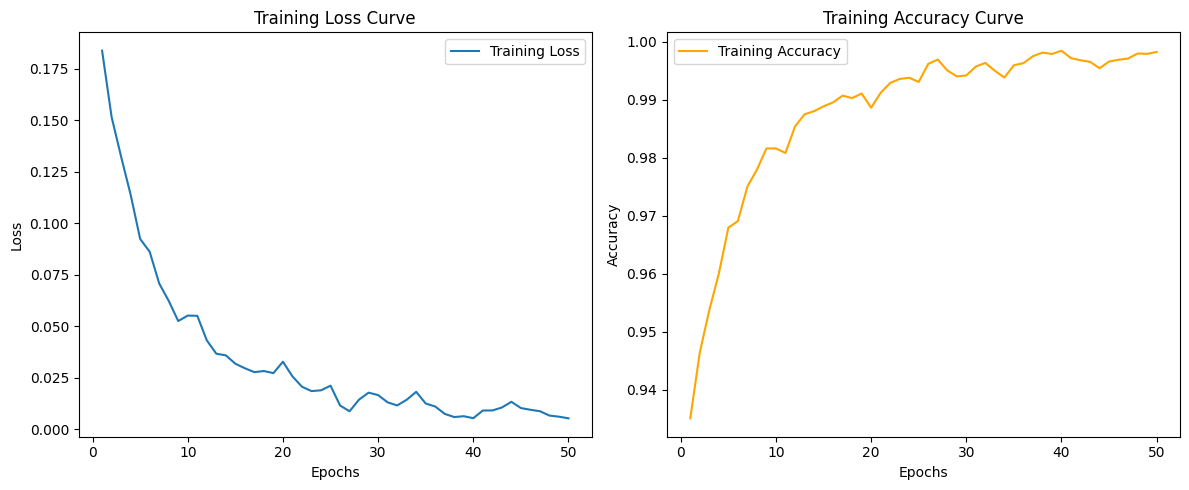

In [23]:
train_losses = []
train_accuracies = []

# Train phase
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Training Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

# Save the model weights
torch.save(model.state_dict(), 'model/model_weights.pth')
print('Model weights saved to model_weights.pth')


plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluate the trained model on test set and print test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy : {test_accuracy}%')

Test Accuracy : 73.57%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [25]:
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy
model.eval()
atk = torchattacks.FGSM(model, eps=1/255)
total = 0
correct = 0
with torch.enable_grad():
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)

        adv_images = atk(data, target)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on FGSM attack with epsilon = 1/255: {accuracy}%')

Accuracy of the model on FGSM attack with epsilon = 1/255: 52.66%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [26]:
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy
model.eval()
atk = torchattacks.FGSM(model, eps=4/255)
total = 0
correct = 0
with torch.enable_grad():
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)

        adv_images = atk(data, target)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on FGSM attack with epsilon = 4/255: {accuracy}%')

Accuracy of the model on FGSM attack with epsilon = 4/255: 21.45%


In [27]:
model.eval()
atk = torchattacks.FGSM(model, eps=8/255)
total = 0
correct = 0
with torch.enable_grad():
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)

        adv_images = atk(data, target)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on FGSM attack with epsilon = 8/255: {accuracy}%')

Accuracy of the model on FGSM attack with epsilon = 8/255: 10.24%


Accuracy of the model on FGSM attack with epsilon = 0/255: 73.57%
Accuracy of the model on FGSM attack with epsilon = 2/255: 35.96%
Accuracy of the model on FGSM attack with epsilon = 4/255: 21.45%
Accuracy of the model on FGSM attack with epsilon = 6/255: 14.19%
Accuracy of the model on FGSM attack with epsilon = 8/255: 10.24%
Accuracy of the model on FGSM attack with epsilon = 10/255: 7.75%
Accuracy of the model on FGSM attack with epsilon = 12/255: 6.29%
Accuracy of the model on FGSM attack with epsilon = 14/255: 5.32%
Accuracy of the model on FGSM attack with epsilon = 16/255: 4.70%


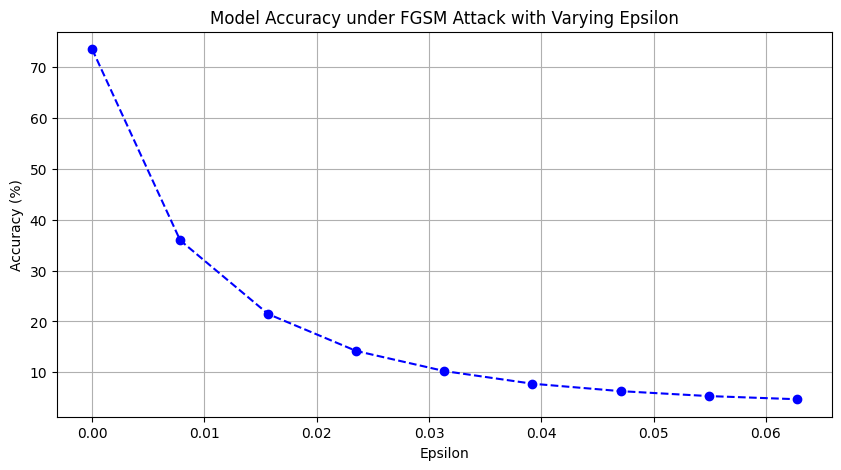

In [29]:
# Define the range of epsilons to test
epsilons = [0/255, 2/255, 4/255, 6/255, 8/255, 10/255, 12/255, 14/255, 16/255]
accuracies = []

model.eval()
for eps in epsilons:
    atk = torchattacks.FGSM(model, eps=eps)
    total = 0
    correct = 0
    with torch.enable_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device)

            adv_images = atk(data, target)
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Accuracy of the model on FGSM attack with epsilon = {int(eps*255)}/255: {accuracy:.2f}%')


plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under FGSM Attack with Varying Epsilon')
plt.grid(True)
plt.show()

In [43]:
def plot_original_and_perturbed(model, images, labels, perturbed_images_list, epsilons):
    num_images = len(images)
    num_epsilons = len(epsilons)
    plt.figure(figsize=(15, 5 * (num_epsilons + 1)))

    # Plot the original images
    for i in range(num_images):
        image = images[i].cpu().squeeze().permute(1, 2, 0).numpy()
        label = labels[i]

        plt.subplot(num_epsilons + 1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Original\nTrue: {classes[label]}")
        plt.axis('off')

    # Plot the perturbed images for each epsilon
    for j, (perturbed_images, epsilon) in enumerate(zip(perturbed_images_list, epsilons)):
        for i in range(num_images):
            perturbed_image = perturbed_images[i].cpu().squeeze().permute(1, 2, 0).numpy()

            with torch.no_grad():
                perturbed_output = model(perturbed_images[i].unsqueeze(0).to(device))
                _, perturbed_pred = torch.max(perturbed_output, 1)

            plt.subplot(num_epsilons + 1, num_images, (j + 1) * num_images + i + 1)
            plt.imshow(perturbed_image)
            plt.title(f"Perturbed\nPred: {classes[perturbed_pred.item()]}\n(ε={epsilon:.3f})")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

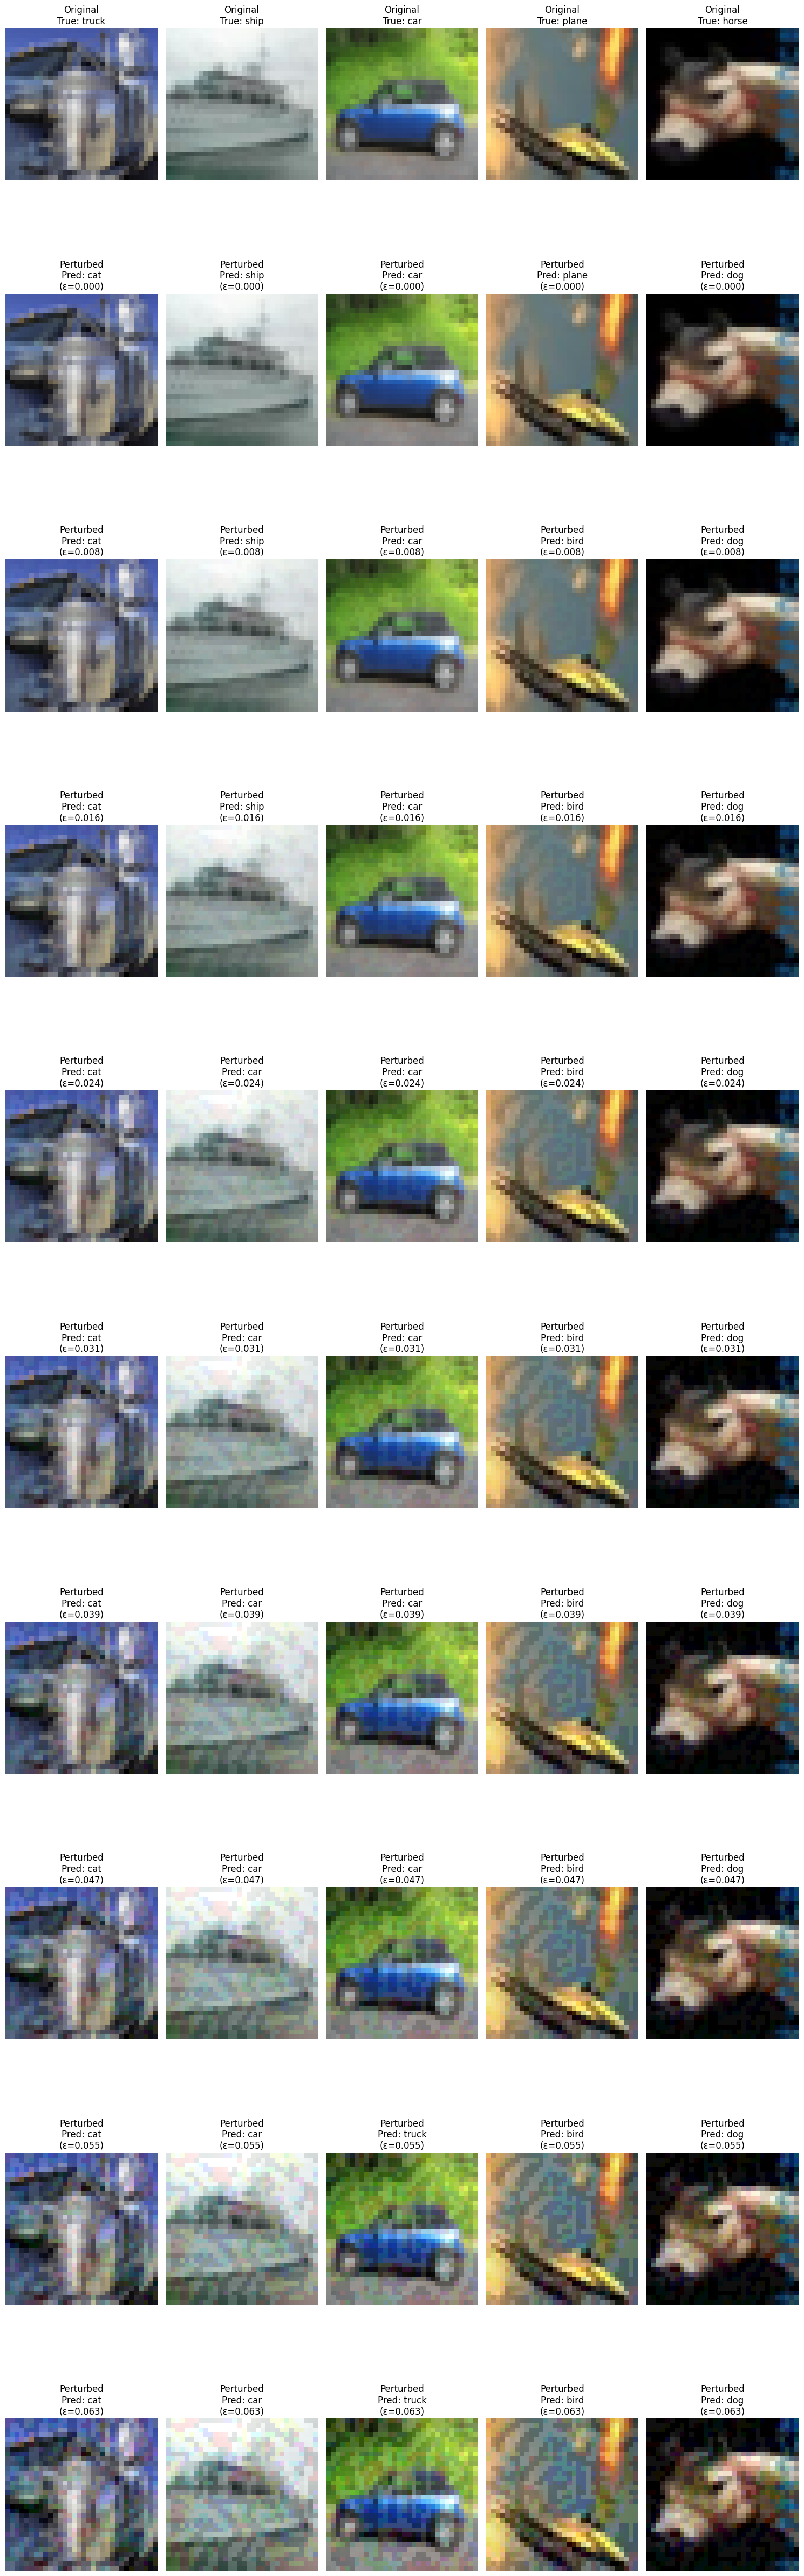

In [54]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 5 random images from the test set
random_indices = random.sample(range(len(images)), 5)
selected_images = [images[idx] for idx in random_indices]
selected_labels = [labels[idx].item() for idx in random_indices]

model.eval()

perturbed_images_list = []
for eps in epsilons:
    atk = torchattacks.FGSM(model, eps=eps)
    perturbed_images = []
    for idx in random_indices:
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)

        perturbed_image = atk(image, label)
        perturbed_images.append(perturbed_image.squeeze().cpu())

    perturbed_images_list.append(perturbed_images)

# Plot the original and perturbed images
plot_original_and_perturbed(model, selected_images, selected_labels, perturbed_images_list, epsilons)

Epoch 1/10: Loss: 0.1316 Accuracy: 0.9459
Epoch 2/10: Loss: 0.1369 Accuracy: 0.9445
Epoch 3/10: Loss: 0.1204 Accuracy: 0.9506
Epoch 4/10: Loss: 0.1189 Accuracy: 0.9512
Epoch 5/10: Loss: 0.1172 Accuracy: 0.9520
Epoch 6/10: Loss: 0.1336 Accuracy: 0.9453
Epoch 7/10: Loss: 0.1278 Accuracy: 0.9475
Epoch 8/10: Loss: 0.1169 Accuracy: 0.9527
Epoch 9/10: Loss: 0.1094 Accuracy: 0.9553
Epoch 10/10: Loss: 0.1143 Accuracy: 0.9543
Model weights saved to adv_model_weights.pth


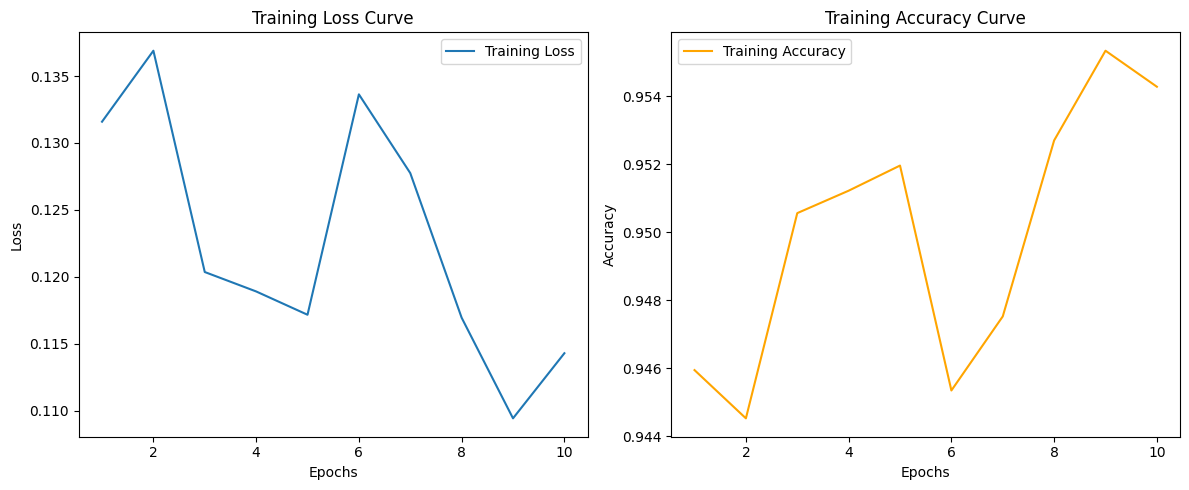

In [56]:
adv_model.train()
atk = torchattacks.FGSM(adv_model, eps=8/255)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 10

train_losses = []
train_accuracies = []


for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        perturbed_data = atk(data, target)

        optimizer.zero_grad()
        outputs = adv_model(perturbed_data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

# Save the model weights
torch.save(adv_model.state_dict(), 'model/adv_model_weights.pth')
print('Model weights saved to adv_model_weights.pth')

# Plot the loss and accuracy learning curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
adv_model.eval()
correct = 0
total = 0
with torch.enable_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = adv_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on Adversarial Model: {test_accuracy}%')

Test Accuracy on Adversarial Model: 61.3%


Accuracy of the adv_model on FGSM attack with epsilon = 0/255: 61.30%
Accuracy of the adv_model on FGSM attack with epsilon = 2/255: 47.27%
Accuracy of the adv_model on FGSM attack with epsilon = 4/255: 37.24%
Accuracy of the adv_model on FGSM attack with epsilon = 6/255: 29.53%
Accuracy of the adv_model on FGSM attack with epsilon = 8/255: 23.35%
Accuracy of the adv_model on FGSM attack with epsilon = 10/255: 18.86%
Accuracy of the adv_model on FGSM attack with epsilon = 12/255: 15.65%
Accuracy of the adv_model on FGSM attack with epsilon = 14/255: 13.41%
Accuracy of the adv_model on FGSM attack with epsilon = 16/255: 11.88%


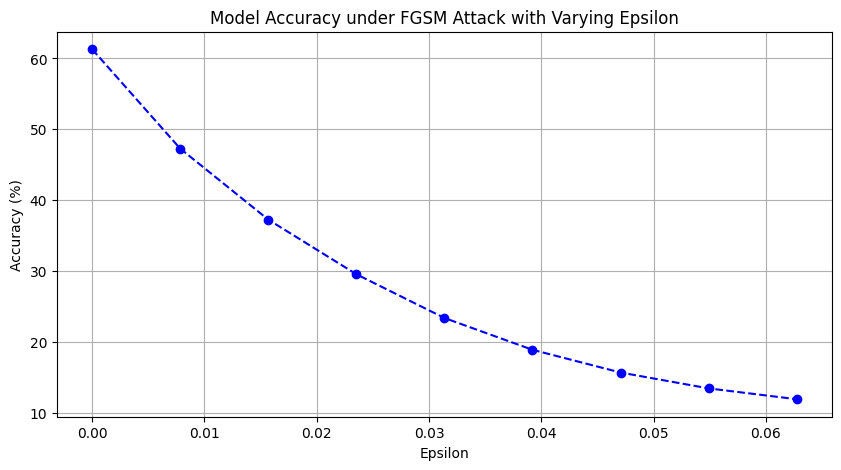

In [59]:
# Define the range of epsilons to test
epsilons = [0/255, 2/255, 4/255, 6/255, 8/255, 10/255, 12/255, 14/255, 16/255]
accuracies = []

adv_model.eval()
for eps in epsilons:
    atk = torchattacks.FGSM(adv_model, eps=eps)
    total = 0
    correct = 0
    with torch.enable_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device)

            adv_images = atk(data, target)
            outputs = adv_model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Accuracy of the adv_model on FGSM attack with epsilon = {int(eps*255)}/255: {accuracy:.2f}%')


plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under FGSM Attack with Varying Epsilon')
plt.grid(True)
plt.show()

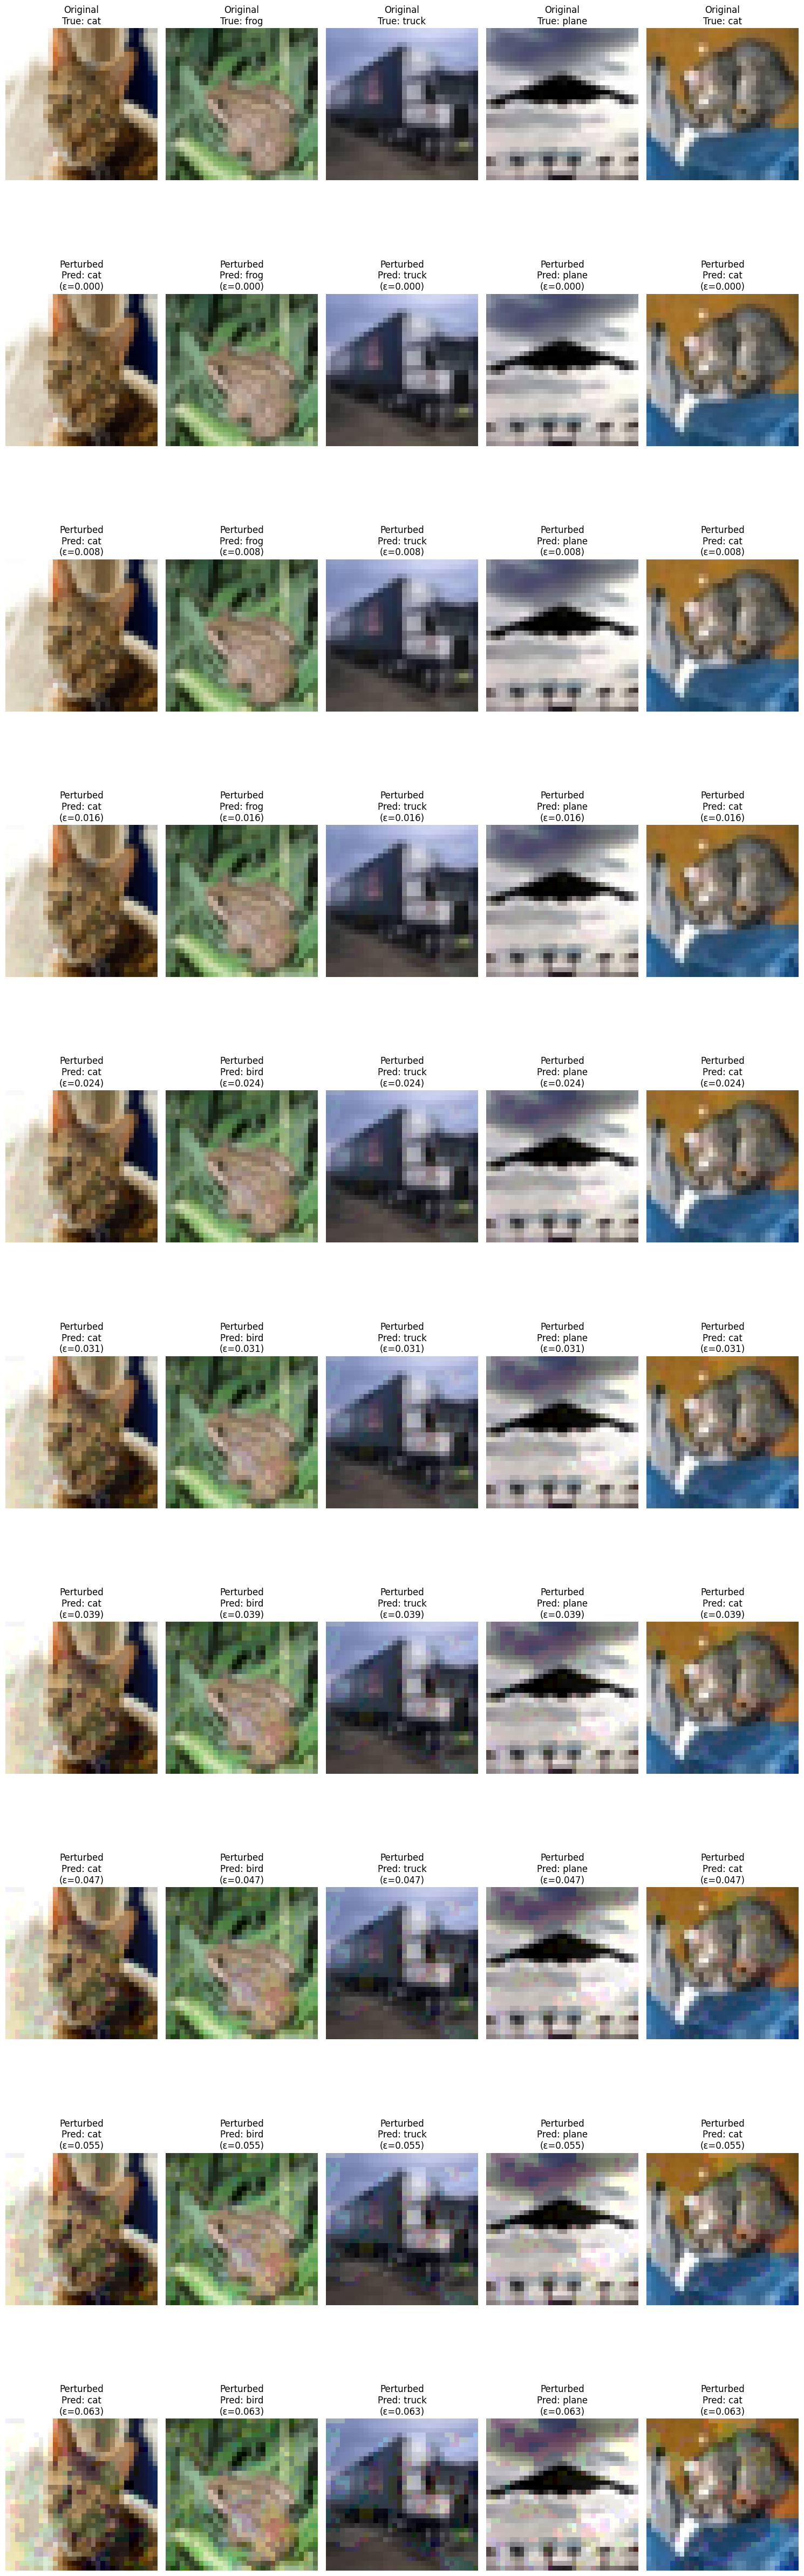

In [60]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 5 random images from the test set
random_indices = random.sample(range(len(images)), 5)
selected_images = [images[idx] for idx in random_indices]
selected_labels = [labels[idx].item() for idx in random_indices]

adv_model.eval()

perturbed_images_list = []
for eps in epsilons:
    atk = torchattacks.FGSM(adv_model, eps=eps)
    perturbed_images = []
    for idx in random_indices:
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)

        perturbed_image = atk(image, label)
        perturbed_images.append(perturbed_image.squeeze().cpu())

    perturbed_images_list.append(perturbed_images)

# Plot the original and perturbed images
plot_original_and_perturbed(model, selected_images, selected_labels, perturbed_images_list, epsilons)